In [3]:
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

In [4]:
from transformers import AutoModelForSequenceClassification
from chop import MaseGraph
import chop.passes as passes

/rds/general/user/oa321/home/miniforge3/envs/mase_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from pathlib import  Path
from chop import MaseGraph

mg = MaseGraph.from_checkpoint(f"{Path.home()}/mase/tasks/tutorial3/best_model")

/rds/general/user/oa321/home/mase/src/chop/ir/graph/mase_graph.py:380: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(f)


In [6]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)


eval_results=trainer.evaluate()
print(f"Base Model Acc: {eval_results['eval_accuracy']}")
print(eval_results)

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
/rds/general/user/oa321/home/mase/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Base Model Acc: 0.83312
{'eval_loss': 0.38564738631248474, 'eval_model_preparation_time': 0.0005, 'eval_accuracy': 0.83312, 'eval_runtime': 24.7418, 'eval_samples_per_second': 1010.438, 'eval_steps_per_second': 126.305}


In [7]:
pc = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local"
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local"
    }
}

In [2]:
import pandas as pd

def search_prune(strat: str) -> None:
    mg = MaseGraph.from_checkpoint(f"{Path.home()}/mase/tasks/tutorial3/best_model")
    prune_pretrain = [0 for i in range(1, 10)]
    prune_ac = [0 for i in range(1, 10)]
    pc_template = pc



    for i in range(1, 10):
        print(f'iter: {i}')
        pc_template["weight"]["sparsity"] = float(i) / 10.0
        pc_template["activation"]["sparsity"] = float(i) / 10.0
        pc_template["activation"]["method"] = strat
        pc_template["weight"]["method"] = strat
        mg, _ = passes.prune_transform_pass(mg, pc_template)

        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
        )

        eval_results = trainer.evaluate()

        prune_pretrain[i-1] = eval_results['eval_accuracy']

        trainer.train()

        eval_results2 = trainer.evaluate()

        prune_ac[i-1] = eval_results2['eval_accuracy']

    data = []

    for i in range(1, 10):
        data.append({
            "sparsity" : float(i)/10.0,
            "pretrain": prune_pretrain[i-1],
            "posttrain": prune_ac[i-1]
        })

    df = pd.DataFrame(data)
    df.to_csv(f"{Path.home()}/mase/tasks/tutorial4/prune_dt_{strat.replace('-', '_')}_1.csv", index=False)


In [ ]:
search_prune("l1-norm")
search_prune("random")

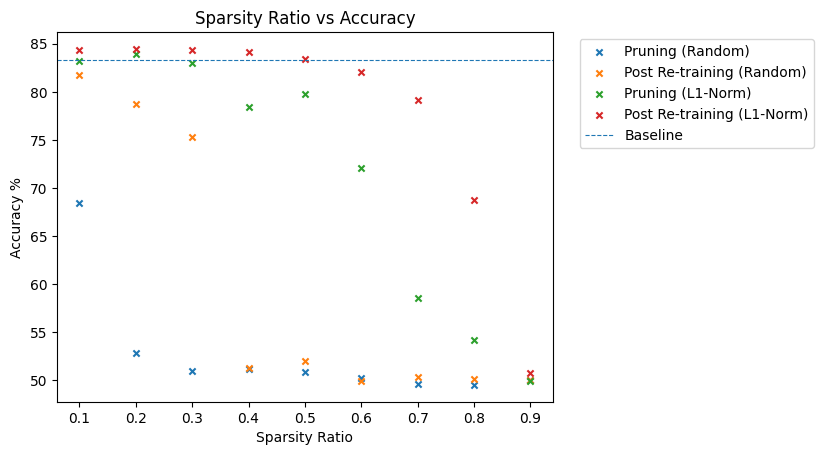

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

df_r = pd.read_csv(f"{Path.home()}/mase/tasks/tutorial4/prune_dt_random.csv")
df_l = pd.read_csv(f"{Path.home()}/mase/tasks/tutorial4/prune_dt_l1_norm.csv")

fig = plt.figure()
plt.scatter(x=df_r['sparsity'], y=df_r['pretrain'] * 100, marker='x', s=20)
plt.scatter(x=df_r['sparsity'], y=df_r['posttrain'] * 100, marker='x', s=20)
plt.scatter(x=df_l['sparsity'], y=df_l['pretrain'] * 100, marker='x', s=20)
plt.scatter(x=df_l['sparsity'], y=df_l['posttrain'] * 100, marker='x', s=20)
plt.axhline(y=eval_results['eval_accuracy'] * 100, linestyle='--', linewidth=0.8)
lgd = plt.legend(['Pruning (Random)', 'Post Re-training (Random)', 'Pruning (L1-Norm)', 'Post Re-training (L1-Norm)', 'Baseline'], bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlabel("Sparsity Ratio")
plt.ylabel("Accuracy %")
plt.title("Sparsity Ratio vs Accuracy")
plt.savefig(f"{Path.home()}/mase/tasks/tutorial4/sparse", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()